# Exploring Classifiers

We should prepare the dataset and the features before running to classification.

Here, all the required code for preprocessing is provided as-is: no need to update them.

In [1]:
import os, sys
import copy
import tarfile
import time
import random
import pickle
from itertools import chain
from pathlib import Path
from glob import glob
from collections import Counter

import gdown

import torch
import torch.nn.functional as F
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
caltech_url = 'https://drive.google.com/uc?id=1enYdrGFhROlTQkvtUooRl4H8oAbGmyXl'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'

# Dataset

## 1. Download Caltech-101 dataset

In [3]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Downloading Caltech-101')
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        gdown.download(caltech_url, caltech_filename, quiet=False)
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Caltech-101 dataset checked


## 2. Setup data

Select 15 train/test images for each class
done


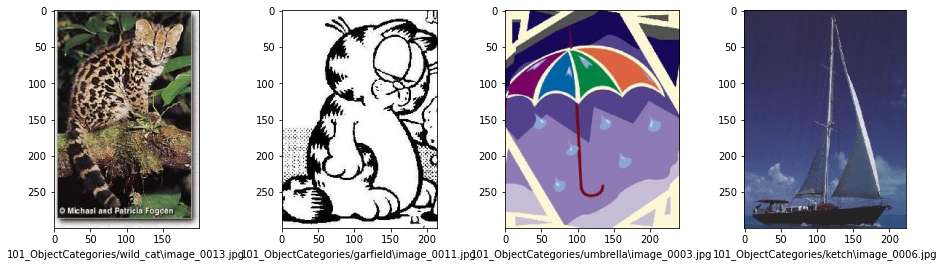

In [4]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

# Dense SIFT(PHOW)

## 1. SIFT helper functions

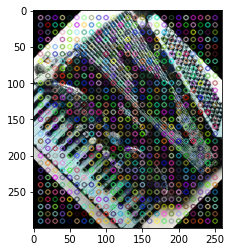

In [5]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

# Visual Words

## 1. Training Visual Words

In [6]:
# Train vocabulary

bf = cv2.BFMatcher()

visual_word_samples = None
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    # Total number of PHOW may be different.
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    if visual_word_samples is None:
        temp = [item for sublist in train_image_ll for item in sublist]
        # sample only once
        temp = random.sample(temp, 30)
        visual_word_samples = temp
    for fpath in visual_word_samples:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)
        
def getImageDescriptor(img, step=10, size=7):
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning
    binX = 1; binY = 1;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    hist = np.concatenate((hist, temp), axis=0)
    hist /= np.sum(hist)
    return hist
    
print('Done!')

Load the trained visual words...
Done!


## 2. Extracting Visual Words

In [7]:
'''
This block may take ~3 minutes depending on the computational resources
'''

num_labels = len(train_image_ll)

class IDMapper:
    def __init__(self):
        self.map = {}
        self.counter = 0
        
    def __call__(self, path):
        name = Path(path).parent.name
        if name not in self.map:
            self.map[name] = self.counter
            self.counter += 1
        return self.map[name]

id_mapper = IDMapper()

data = {
    'train': list(chain(*[[(getImageDescriptor(img), id_mapper(img)) for img in category] for category in train_image_ll])),
    'test': list(chain(*[[(getImageDescriptor(img), id_mapper(img)) for img in category] for category in test_image_ll])),
}

feature, label = zip(*data['train'])
data['train'] = {'feature': np.stack(feature, axis=0), 'label': np.array(label)}
feature, label = zip(*data['test'])
data['test'] = {'feature': np.stack(feature, axis=0), 'label': np.array(label)}
print('Done!')

Done!


# Classifier - kNN

## 1. Euclidean Distance

k - Nearest Neighbour aggregates labels of the nearest neighbours to yield a conclusion.

To determine those nearest neighbours, we need a definition of distance between a pair of datapoints.

Let us implement euclidean distance here.

In [9]:
K = 5

def calculate_euclidean_distance(target, sources):
    distances = _calculate_euclidean_distance(target, sources)
    assert len(distances.shape) == 1 and distances.shape[0] == sources.shape[0], 'distance output must be of shape (knn_train_samples,)'
    return distances


def _calculate_euclidean_distance(target, sources):
    
    ##################################
    #Question 1.1: Fill in this blank#
    #        START CODE HERE         #
    distances = np.zeros((sources.shape[0],))
    for i in range(sources.shape[0]):
        distances[i] = np.linalg.norm(target - sources[i])
    #         END CODE HERE          #
    #                                #
    ##################################
    return distances


accuracy = []
testset_size = len(data['test']['label'])
for idx in tqdm(range(testset_size), total=testset_size):
    feature = data['test']['feature'][idx]
    distances = calculate_euclidean_distance(feature, data['train']['feature'])
    nns = torch.from_numpy(distances).topk(K, dim=0, largest=False).indices
    predictions = Counter(data['train']['label'][nns.numpy()])
    prediction = predictions.most_common(1)[0][0]
    target = data['test']['label'][idx]
    correct = float(prediction == target)
    accuracy.append(correct)
accuracy = np.array(accuracy).mean()
print(f'k(={K})NN accuracy: {accuracy * 100:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:17<00:00, 86.15it/s]

k(=5)NN accuracy: 19.74%


## 2. kNN Hyperparameter Tuning

How do we know what is a feasible value for the hyperparameters, say the number of neighbours, to consider?

We challenge you to obtain **>=25%** accuracy by modifying two variables: K and the distance function.

When implementing the distance function, be sure not to use the test data.

In [10]:
my_K = 5

def run_knn(K, calculate_distance):
    accuracy = []
    testset_size = len(data['test']['label'])
    for idx in tqdm(range(testset_size), total=testset_size):
        feature = data['test']['feature'][idx]
        distances = calculate_distance(feature, data['train']['feature'])
        nns = torch.from_numpy(distances).topk(K, dim=0, largest=False).indices
        predictions = Counter(data['train']['label'][nns.numpy()])
        prediction = predictions.most_common(1)[0][0]
        target = data['test']['label'][idx]
        correct = float(prediction == target)
        accuracy.append(correct)
    accuracy = np.array(accuracy).mean()
    print(f'k(={K})NN accuracy: {accuracy * 100:.2f}%')
    return accuracy

##################################
#   Question 1.2: Modify these   #
#        START CODE HERE         #
def calculate_my_distance(target, sources):
    distances = np.zeros((sources.shape[0],))
    for i in range(sources.shape[0]):
        distances[i] = np.linalg.norm(target - sources[i],1)

    return distances
#         END CODE HERE          #
#                                #
##################################
    
run_knn(my_K, calculate_my_distance)

100%|██████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:20<00:00, 73.31it/s]

k(=5)NN accuracy: 30.65%


0.3065359477124183

# Classifier - Naive Bayes

## 1. Counting

In [11]:
def reduce_channels(v, c=100):
    B, D = v.shape
    v = v[:, :, None].reshape((B, c, D // c))
    v = v.mean(-1)
    return v
    

nb_features = {
    'train': reduce_channels(data['train']['feature']),
    'test': reduce_channels(data['test']['feature']),
}

n_features = nb_features['train'].shape[1]
n_classes = len(id_mapper.map)

nb_stats = {
    'mean': np.zeros((n_classes, n_features)),
    'var': np.zeros((n_classes, n_features)),
    'prior': np.zeros(n_classes, dtype=np.float64)
}

for i in range(n_classes):
    mask = data['train']['label'] == i
    ids = mask.nonzero()[0]
    feat_cls = nb_features['train'][ids]
    
    ##################################
    #   Question 2.1: Modify these   #
    #     Hint: update nb_stats      #
    #        START CODE HERE         #
    nb_stats['mean'][i] = np.mean(feat_cls,axis=0)
    nb_stats['var'][i]  = np.var(feat_cls,axis=0)
    nb_stats['prior'][i] += 1/n_classes 
    
    #         END CODE HERE          #
    #                                #
    ##################################

## 2. Inference

In [12]:
def calculate_likelihood(class_idx, x, eps=1e-10):
    mean = nb_stats['mean'][class_idx]
    var = nb_stats['var'][class_idx]
    
    ##################################
    #  Question 2.2: Fill the blank  #
    #        START CODE HERE         #
    num   = np.exp(-((x-mean)**2 / (2*(var+eps))))
    denom = np.sqrt(2 * np.pi * (var+eps))
    #         END CODE HERE          #
    #                                #
    ##################################
    
    return num / (denom + eps) 


def get_posteriors(x, eps=1e-10):
    posteriors = []
    # posterior for each class
    for i in range(n_classes):
        prior = np.log(nb_stats['prior'][i])
        
        ##################################
        #  Question 2.3: Fill the blank  #
        #        START CODE HERE         #
        likelihood = np.log(calculate_likelihood(i, x))
        posterior = np.sum(likelihood) + prior
        #         END CODE HERE          #
        #                                #
        ##################################
        
        posteriors.append(posterior)
    # class with highest posterior
    return posteriors
    
def classify_sample(x, eps=1e-10):
    posteriors = get_posteriors(x)
    return np.argmax(posteriors).item()

accuracy = []
for idx, feat in tqdm(enumerate(nb_features['test'])):
    pred = classify_sample(feat)
    target = data['test']['label'][idx]
    correct = float(pred == target)
    accuracy.append(correct)

accuracy = np.array(accuracy).mean()
print(f'Naive Bayes accuracy: {accuracy * 100:.2f}%')

0it [00:00, ?it/s]<ipython-input-12-c95cb4223d0b>:26: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(calculate_likelihood(i, x))
1530it [00:03, 415.31it/s]

Naive Bayes accuracy: 21.90%


# Classifier - Linear SVM

## 1. Training

In [44]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
train_bow = copy.deepcopy(data['train']['feature'].astype(np.float32))

# Hellinger's kernel
train_bow = np.sqrt(train_bow)
train_bow -= np.mean(train_bow, axis=-1, keepdims=True)
std = np.std(train_bow, axis=-1, keepdims=True)
mask = std != 0
train_bow = train_bow / (mask.astype(np.float32) * std) 

train_labels = data['train']['label'][:, None]
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

print('Done!')

train_preds = svm.predict(train_bow)[1]
print(f'Training Accuracy: {(np.average(train_preds == train_labels) * 100):.2f}')

Training SVM...
Elapsed time: 1.2590017318725586s
Done!
Training Accuracy: 97.39


## 2. Prediction

Given a trained SVM, write an inference code to extract top 1 labels for each of the test data.

In [43]:
svm.predict(test_bow)[0]
data['test']['label'][:, None][:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [45]:
print('Extract top-1 labels for the first ten test images\n')

# Hellinger's kernel
test_bow = copy.deepcopy(data['test']['feature'].astype(np.float32))
test_bow = np.sqrt(test_bow)
test_bow -= np.mean(test_bow, axis=-1, keepdims=True)
std = np.std(test_bow, axis=-1, keepdims=True)
mask = std != 0
test_bow = test_bow / (mask.astype(np.float32) * std) 

predictions = []

##################################
#    Question 3: Modify these    #
#        START CODE HERE         #
predictions = list(svm.predict(test_bow)[1].flatten())
#         END CODE HERE          #
#                                #
##################################

# get text label name
reverse_map = {v: k for k, v in id_mapper.map.items()}
text_predictions = [reverse_map[p] for p in predictions]
   
assert isinstance(predictions, list), "variable prediction should be a list"
assert all([isinstance(v, str) for v in text_predictions]), "each row in variable predictions should be a single string of the label name"
print('\ndone!')


print(text_predictions[:10])


Extract top-1 labels for the first ten test images


done!
['accordion', 'accordion', 'accordion', 'butterfly', 'accordion', 'accordion', 'accordion', 'accordion', 'accordion', 'accordion']


# Precision-Recall Curve

In an imbalanced classification problem, you would use precision and recall to measure classification performance.

Let us draw a precision-recall curve to visualize tradeoff between precision and recall.

Here, we formulate caltech101 as a binary classification problem which classifies whether the given image is an animal or not.

To compute precision and recall, we first count false positive, false negative, true positive and true negative instances from the test dataset.
Then we compute precision and recall.

We need the **get_posteriors** function of Naive Bayes for this problem.

0it [00:00, ?it/s]<ipython-input-12-c95cb4223d0b>:26: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(calculate_likelihood(i, x))
1530it [00:03, 437.02it/s]


[1.0, 0.2143109957132682, 0.045929202883612456, 0.009843133202303695, 0.002109491677524035, 0.00045208726185902865, 9.688727123829339e-05, 2.0764007571020135e-05, 4.449955137543167e-06, 9.5367431640625e-07, 0]


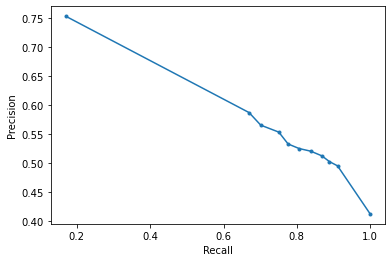

In [15]:
animals = ['dolphin', 'octopus', 'crocodile_head', 'flamingo_head', 'pigeon', 'butterfly', 'scorpion', 'sea_horse', 'Leopards', 'crab',
           'gerenuk', 'ibis', 'crayfish', 'beaver', 'emu', 'hawksbill', 'elephant', 'rhino', 'dragonfly', 'panda', 'llama', 'flamingo',
           'brontosaurus', 'mayfly', 'starfish', 'stegosaurus', 'Faces', 'cougar_face', 'kangaroo', 'trilobite', 'wild_cat', 'Faces_easy',
           'nautilus', 'ant', 'hedgehog', 'platypus', 'okapi', 'crocodile', 'rooster', 'cougar_body', 'lobster', 'dalmatian']
animal_indices = [v for k, v in id_mapper.map.items() if k in animals]

tgts = data['test']['label']
tgts = [v in animal_indices for v in tgts]

logits = []
for idx, feat in tqdm(enumerate(nb_features['test'])):
    pred = get_posteriors(feat)
    logits.append(pred)
probs = F.softmax(torch.Tensor(logits), dim=-1)
animal_probs = probs[:, animal_indices].sum(-1)

thresholds = [*(2 ** (-np.linspace(0, 20, 10))), 0]
print(thresholds)
counts = {}
for level in thresholds:
    counts[level] = {
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }
    for prob, tgt in zip(animal_probs, tgts):
        # use prob, tgt, level
        # Hint: we assign "positive" when prob >= level
        ##################################
        #   Question 4.1: Modify these   #
        #        START CODE HERE         #
        good = prob >= level
        if tgt and good: flag = 'tp'
        elif tgt and not good: flag = 'fn'
        elif not tgt and good: flag = 'fp'
        else: flag = 'tn'
        #         END CODE HERE          #
        #                                #
        ##################################
        counts[level][flag] += 1
        
tp = np.array([counts[level]['tp'] for level in thresholds])
fp = np.array([counts[level]['fp'] for level in thresholds])
tn = np.array([counts[level]['tn'] for level in thresholds])
fn = np.array([counts[level]['fn'] for level in thresholds])

##################################
#   Question 4.2: Modify these   #
#        START CODE HERE         #
recall = tp/(tp+fn)
precision = tp/(tp+fp)
#         END CODE HERE          #
#                                #
##################################


fig, ax = plt.subplots()
ax.plot(recall, precision, marker='.', label='animals PR Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()